In [ ]:
!pip install fastbook -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from fastbook import *
from fastai.vision.widgets import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/Dataset/car')
#作業這行要改
keywords = {'Porsche 718' : 'porsche 718', 'Porsche 911' : 'porsche 911', 'Porsche Taycan': 'porsche taycan', 'Porsche Panamera':'porsche panamera'}

array = keywords.items()

if not path.exists():
  !mkdir -p /content/drive/MyDrive/Dataset/car
  for key, value in array:
    print(key, value)
    dest = (path/key)
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f'{value}', max_images=100)
    download_images(dest, urls=urls)

In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [ ]:
path = Path('/content/drive/MyDrive/Dataset/car')
#linux語法列出路徑下的檔案
path.ls()

(#3) [Path('/content/drive/MyDrive/Dataset/car/Porsche 718'),Path('/content/drive/MyDrive/Dataset/car/Porsche 911'),Path('/content/drive/MyDrive/Dataset/car/Porsche Taycan')]

In [ ]:
myPath='/content/drive/MyDrive/Models'
!mkdir -p $myPath

dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    get_y=parent_label
)

dls = dataset.dataloaders(path, bs=16, num_workers=16)

print(dls.c, dls.vocab, len(dls.train_ds), len(dls.valid_ds))

3 ['Porsche 718', 'Porsche 911', 'Porsche Taycan'] 229 57


train_data


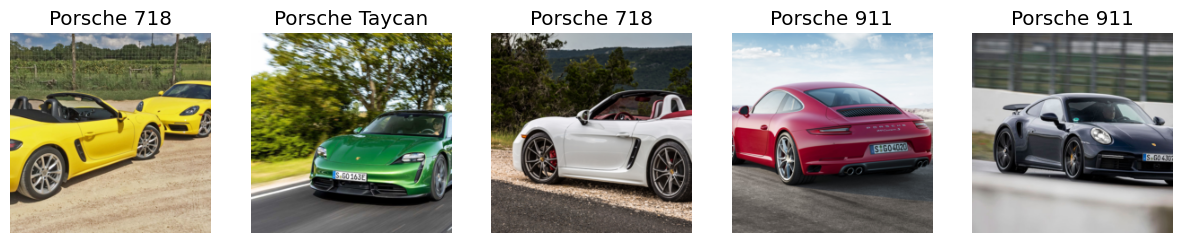

In [ ]:
print('train_data')
dls.show_batch(max_n=5, nrows=1)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], pretrained=True)
learn.fit_one_cycle(3, 1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 140MB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.811783,1.211362,0.526316,0.473684,00:48
1,1.195662,0.697925,0.701754,0.298246,00:38
2,0.899365,0.611105,0.754386,0.245614,00:41


In [ ]:
myModel = myPath+'/resnet34_stage-1.pkl'
learn.export(myModel)

Minimum/10: 1.45e-04, steepest point:6.31e-07


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.471882,0.422242,0.842105,0.157895,00:40
1,0.505041,0.425666,0.877193,0.122807,00:38
2,0.437083,0.621650,0.807018,0.192982,00:43
3,0.371476,0.733281,0.842105,0.157895,00:35
4,0.280064,0.796182,0.859649,0.140351,00:30
5,0.236325,0.781356,0.842105,0.157895,00:32


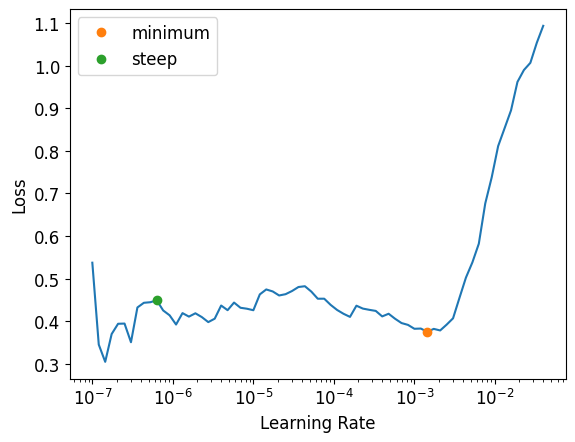

In [ ]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f'Minimum/10: {lr_min:.2e}, steepest point:{lr_steep:.2e}')

learn.fit_one_cycle(6, lr_max=2.75e-04)

In [ ]:
myModel = myPath+'/resnet34_stage-2.pkl'
learn.export(myModel)

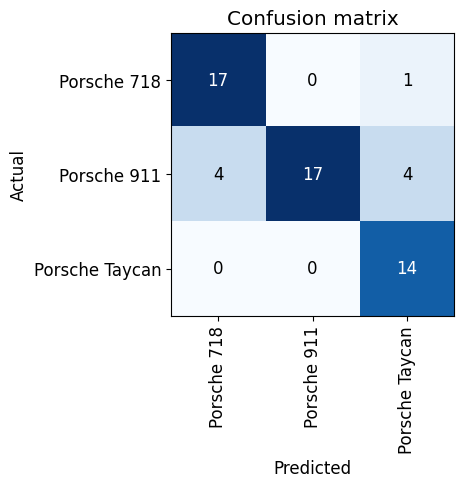

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

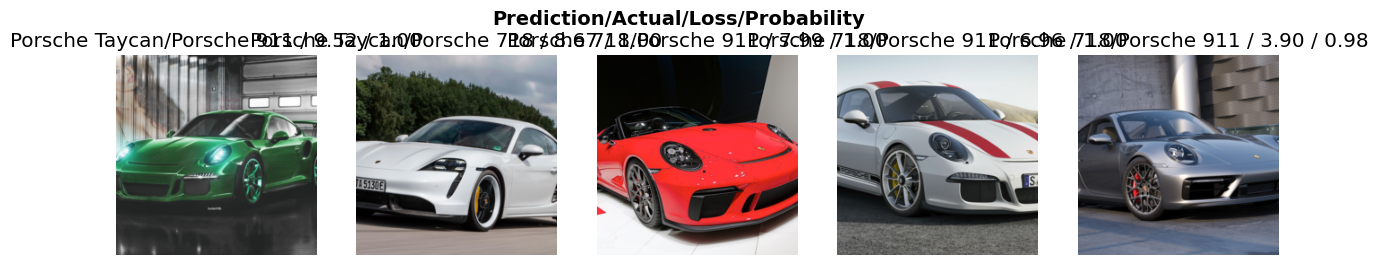

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
fnames_Porsche_718 = get_image_files('/content/drive/MyDrive/Dataset/car/Porsche 718')
fnames_Porsche_911 = get_image_files('/content/drive/MyDrive/Dataset/car/Porsche 911')
fnames_Porsche_Taycan = get_image_files('/content/drive/MyDrive/Dataset/car/Porsche Taycan')

pred_class, pred_idx, outputs = learn.predict(fnames_Porsche_718[3])
print('Actual: Porsche 718, Predicted = {}'.format(pred_class))

pred_class, pred_idx, outputs = learn.predict(fnames_Porsche_Taycan[7])
print('Actual: Porsche Taycan, Predicted = {}'.format(pred_class))

Actual: Porsche 718, Predicted = Porsche 718


Actual: Porsche Taycan, Predicted = Porsche Taycan


In [ ]:
class Hook():
  def __init__(self, m):
    self.hook = m.register_forward_hook(self.hook_func)
  def hook_func(self, m, i, o):self.stored = o.detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args):self.hook.remove()

In [ ]:
class HookBwd():
  def __init__(self, m):
    self.hook = m.register_backward_hook(self.hook_func)
  def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [ ]:
fnames_Porsche_Taycan = get_image_files('/content/drive/MyDrive/Dataset/car/Porsche Taycan')
test_dl = learn.dls.test_dl(fnames_Porsche_Taycan, with_label=True)


In [ ]:
from torchvision.transforms.functional import to_tensor

fn = test_dl.items[0]
x_dec = PILImage.create(fn)

rsz = Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
x_dec = rsz(x_dec)
x = to_tensor(x_dec)
x.unsqueeze_(0)
x.shape, type(x)

(torch.Size([1, 3, 224, 224]), torch.Tensor)

In [ ]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
  with Hook(learn.model[0]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0, cls].backward()
  grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1, 2], keepdim=True)
cam_map = (w*act[0]).sum(0)

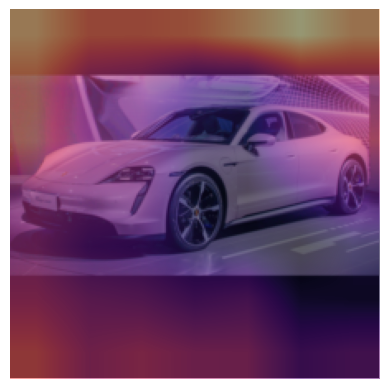

In [ ]:
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0), interpolation='bilinear', cmap='magma')
